<a href="https://colab.research.google.com/github/Hemantr05/msrit-ai-in-medicine/blob/master/demos/images/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Hemantr05/msrit-ai-in-medicine

In [ ]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

     |████████████████████████████████| 1.1 MB 4.0 MB/s 
     |████████████████████████████████| 95.3 MB 1.5 MB/s 
     |████████████████████████████████| 16.6 MB 15.9 MB/s 
     |████████████████████████████████| 54.5 MB 56 kB/s 
     |████████████████████████████████| 15.0 MB 54.8 MB/s 
     |████████████████████████████████| 20.3 MB 1.3 MB/s 
     |████████████████████████████████| 70.6 MB 13 kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import random
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
from google.colab.patches import cv2_imshow
from monai.networks.nets import DenseNet121


from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.data import Dataset, DataLoader


In [ ]:
device = torch.device("cuda:0")

labels = ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
num_class = len(labels)
idx2label = {idx: i for idx, i in enumerate(labels)}


val_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=num_class)

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


In [ ]:
model = DenseNet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=num_class
).to(device)

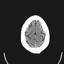

In [ ]:
import glob
class MedNISTDataset(Dataset):

    def __init__(self, image_files, transforms):
        self.image_files = image_files
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index])

image = [i for i in glob.glob("/content/msrit-ai-in-medicine/images/*.jpeg")]
for i in image:
  im = Image.open(i)
  arr = np.array(im)
  cv2_imshow(arr)

val_ds = MedNISTDataset(image, val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

In [ ]:
model_name = "best_metric_model" #@param {type:"string"}
model_name = f'/content/drive/MyDrive/{model_name}.pth' 
model.load_state_dict(torch.load(f'{model_name}')) 
# model.load_state_dict(torch.load(f'{model_name}', map_location=torch.device('cpu'))) 
model.eval()

DenseNet121(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchN

In [ ]:
with torch.no_grad():
    for test_data in val_loader:
        test_images = test_data.to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            class_ = idx2label[pred[i].item()]
            print(class_)

HeadCT
